# CNN

Напомню, свертки - это то, с чего начался хайп нейронных сетей в районе 2012-ого.

Работают они примерно так:  
![Conv example](https://image.ibb.co/e6t8ZK/Convolution.gif)   
From [Feature extraction using convolution](http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution).

Формально - учатся наборы фильтров, каждый из которых скалярно умножается на элементы матрицы признаков. На картинке выше исходная матрица сворачивается с фильтром
$$
 \begin{pmatrix}
  1 & 0 & 1 \\
  0 & 1 & 0 \\
  1 & 0 & 1
 \end{pmatrix}
$$

Но нужно не забывать, что свертки обычно имеют ещё такую размерность, как число каналов. Например, картинки имеют обычно три канала: RGB.  
Наглядно демонстрируется как выглядят при этом фильтры [здесь](http://cs231n.github.io/convolutional-networks/#conv).

После сверток обычно следуют pooling-слои. Они помогают уменьшить размерность тензора, с которым приходится работать. Самым частым является max-pooling:  
![maxpooling](http://cs231n.github.io/assets/cnn/maxpool.jpeg)  
From [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/#pool)

### Свёртки для текстов

Для текстов свертки работают как n-граммные детекторы (примерно). Каноничный пример символьной сверточной сети:

![text-convs](https://image.ibb.co/bC3Xun/2018_03_27_01_24_39.png)  
From [Character-Aware Neural Language Models](https://arxiv.org/abs/1508.06615)

*Сколько учится фильтров на данном примере?*

На картинке показано, как из слова извлекаются 2, 3 и 4-граммы. Например, желтые - это триграммы. Желтый фильтр прикладывают ко всем триграммам в слове, а потом с помощью global max-pooling извлекают наиболее сильный сигнал.

Что это значит, если конкретнее?

Каждый символ отображается с помощью эмбеддингов в некоторый вектор. А их последовательности - в конкатенации эмбеддингов.  
Например, "abs" $\to [v_a; v_b; v_s] \in \mathbb{R}^{3 d}$, где $d$ - размерность эмбеддинга. Желтый фильтр $f_k$ имеет такую же размерность $3d$.  
Его прикладывание - это скалярное произведение $\left([v_a; v_b; v_s] \odot f_k \right) \in \mathbb R$ (один из желтых квадратиков в feature map для данного фильтра).

Max-pooling выбирает $max_i \left( [v_{i-1}; v_{i}; v_{i+1}] \odot f_k \right)$, где $i$ пробегается по всем индексам слова от 1 до $|w| - 1$ (либо по большему диапазону, если есть padding'и).   
Этот максимум соответствует той триграмме, которая наиболее близка к фильтру по косинусному расстоянию.

В результате в векторе после max-pooling'а закодирована информация о том, какие из n-грамм встретились в слове: если встретилась близкая к нашему $f_k$ триграмма, то в $k$-той позиции вектора будет стоять большое значение, иначе - маленькое.

А учим мы как раз фильтры. То есть сеть должна научиться определять, какие из n-грамм значимы, а какие - нет.


## Основные параметры сверток

### Stride

Stride - это "шаг" с которым идем по матрице объекта

<img src="strides.gif">

### Dilation

Dilation - расстояние между точками ядра

<img src="dilations.png">

In [33]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [34]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)

def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]
    
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=3)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [35]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_three = nn.Dropout(0.2)
        self.dp_four = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 30, 3)
        self.bn_two = torch.nn.BatchNorm2d(30) 
        self.conv_two = torch.nn.Conv2d(30, 60, 3)
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(480, 200)
        self.fc2 = torch.nn.Linear(200, 150)
        self.out = torch.nn.Linear(150, 100)
        
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_three(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_four(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)
       
net = Net().cuda()
print(net)

Net(
  (dp_three): Dropout(p=0.2, inplace=False)
  (dp_four): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=150, bias=True)
  (out): Linear(in_features=150, out_features=100, bias=True)
)


In [36]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [37]:
for epoch in tqdm(range(2)):  
    net.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].cuda(), data[1].cuda()
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    net.eval()
    loss_accumed = 0
    for X, y in valid_loader:
        X, y = X.cuda(), y.cuda()
        output = net(X)
        loss = criterion(output, y)
        loss_accumed += loss
    print("Epoch {} valid_loss {}".format(epoch, loss_accumed))

print('Training is finished!')

 50%|█████     | 1/2 [00:15<00:15, 15.43s/it]

Epoch 0 valid_loss 79.64630126953125


100%|██████████| 2/2 [00:30<00:00, 15.44s/it]

Epoch 1 valid_loss 78.53933715820312
Training is finished!


# CNN проблемы:

1. Проблема сложность обобщения картинки

Первая продвинутая сверточная архитектура - Alexnet

<img src="alexnet.png">

Развитие - более тяжелые сети VGG

<img src="vgg.png">

<img src="vgg2.jpg">

2. Проблема затухания градиентов - resnet, inception

<img src="resnet.png">

<img src="inception_big.png">
<img src="inception.jpg">

In [38]:
from torchvision import models

resnet50 = models.resnet50()
alexnet = models.alexnet()
vgg16 = models.vgg16()
#inception = models.inception_v3()

In [39]:
resnet50 = models.resnet50(pretrained=True)
alexnet = models.alexnet(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
#inception = models.inception_v3(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 304MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

In [40]:
# Необходимые трансформации
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), normalize, transforms.ToTensor()])

Но в жизни часто нужно решать какую-то свою задачу, а не ImageNet

<img src="frozen.png">

In [41]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [42]:
# print(vgg16)

In [43]:
resnet50 = models.resnet50(pretrained=True)
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [44]:
set_parameter_requires_grad(resnet50, True)
resnet50.fc = nn.Linear(2048, 100)
resnet50 = resnet50.to('cuda')

In [45]:
trans_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=3)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

In [46]:
# params_to_update

In [47]:
params_to_update = []
for name,param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [48]:
for epoch in tqdm(range(2)):  
    resnet50.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].cuda(), data[1].cuda()
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    resnet50.eval()
    loss_accumed = 0
    for X, y in valid_loader:
        X, y = X.cuda(), y.cuda()
        output = resnet50(X)
        loss = criterion(output, y)
        loss_accumed += loss
    print("Epoch {} valid_loss {}".format(epoch, loss_accumed))

print('Training is finished!')

 50%|█████     | 1/2 [02:35<02:35, 155.35s/it]

Epoch 0 valid_loss 251.0553741455078


100%|██████████| 2/2 [05:09<00:00, 154.53s/it]

Epoch 1 valid_loss 307.85906982421875
Training is finished!


In [49]:
transform1 = transforms.Compose([transforms.RandomResizedCrop(size=32, scale=(0.08, 1.0), ratio=(0.75, 1.33), interpolation=2), transforms.ToTensor()])

dataset = datasets.CIFAR100(root='data/', download=True, transform=transforms.ToTensor())
datasetplus = datasets.CIFAR100(root='data/', download=True, transform=transform1) 
# This "datasetplus" is to increase the dataset with more images

test_dataset = datasets.CIFAR100(root='data/', train=False, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [50]:
dataset_size = len(datasetplus) + len(dataset)

In [51]:
random_seed = 42
torch.manual_seed(random_seed);

val_size = 10000
train_size = dataset_size - val_size

train_ds, val_ds = torch.utils.data.random_split((dataset+datasetplus), [train_size, val_size])
len(train_ds), len(val_ds)

(90000, 10000)

In [52]:
batch_size = 32

train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


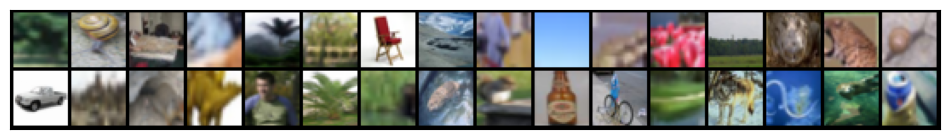

In [53]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_dl)

In [54]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [55]:
import torchvision

class CIFAR100Model(ImageClassificationBase):
        def __init__(self):
                super().__init__()
                self.network = torchvision.models.resnet50()
                num_ftrs = self.network.fc.in_features
                self.network.fc = nn.Linear(num_ftrs, 100)
        
        def forward(self, xb):
                return self.network(xb)
            
model = CIFAR100Model()
model

CIFAR100Model(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [56]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [57]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, 
        weight_decay=0, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [58]:
# For this model we gonna use Adam Optimization
opt_func = torch.optim.Adam
weight_decay = 5e-4
grad_clip = 0.1

In [59]:
# For this model we gonna use Adam Optimization
opt_func = torch.optim.Adam
weight_decay = 5e-4
grad_clip = 0.1

In [60]:
test_loader = DeviceDataLoader(torch.utils.data.DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 5.285830020904541, 'val_acc': 0.00995222944766283}